In [1]:
import tensorflow as tf

import pandas as pd
import re
from google.colab import files
import string
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load('en_core_web_sm')

import nltk
nltk.download('words')
nltk.download('brown')
from nltk.corpus import brown
words = set(brown.words())
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb
from sklearn.metrics import f1_score

import pickle

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### I have converted a dataset found here https://github.com/JAIJANYANI/Automated-Resume-Screening-System to a csv dataset.


In [2]:
uploaded = files.upload()
conteudoUploaded = str(uploaded)
nomeArquivo = re.findall(r"'(.*?)'", conteudoUploaded, re.DOTALL)

df = pd.read_csv(nomeArquivo[0], index_col = False, dtype=str)
df.columns = ['idx','target','text']
df = df[df['text'].notna()]

df.head()

Saving final.csv to final.csv


,idx,target,text
0,0,0,CHARLOTTE WONG – CURRIC...
1,1,0,TEE SHIN YIN ...
2,2,0,Karlyn Neo Office Manager (1 year 6 months) AS...
3,3,0,RESUME ...
4,4,0,"PERSONAL DETAILS Name : CHAN,..."


### **EDA**

First, we need to get some information.
Few information will be removed, as stopwords, ponctuations and etc. But, comparing to other NLP problems, resumes/CVs have no character or word limit, and probably have differences from other common texts, as tweets, news, books and poems. Let's check few things, entities and texts lenght.

So, first it is important to clean the text, all this texts have been converted from .pdf, .doc files, few garbage symbols, and extra spaces need to be removed.Then, I will check up how many of each data is names, dates, places.

In [3]:
def clean_text(text):
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('|', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', '', text)
    return text

def entity_counter(text):
  doc = nlp(text)
  return len(doc.ents)  

In [4]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['entity_count'] = df['text'].apply(lambda x: entity_counter(x))
df

,idx,target,text,word_count,entity_count
0,0,0,CHARLOTTE WONG CURRICU...,1377,123
1,1,0,TEE SHIN YIN ...,207,16
2,2,0,Karlyn Neo Office Manager year months ASK Ca...,893,87
3,3,0,RESUME ...,789,75
4,4,0,PERSONAL DETAILS Name CHAN H...,1324,88
...,...,...,...,...,...
538,538,4,Dianne Loke AiFen Tel Academic History and ...,2207,180
539,539,4,Ng Aik ...,808,75
540,540,4,Chloe Song Singapore Associate at Colin Ng Pa...,99,23
541,541,4,Reuben Lee Legal Associate months Metropolita...,435,57


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


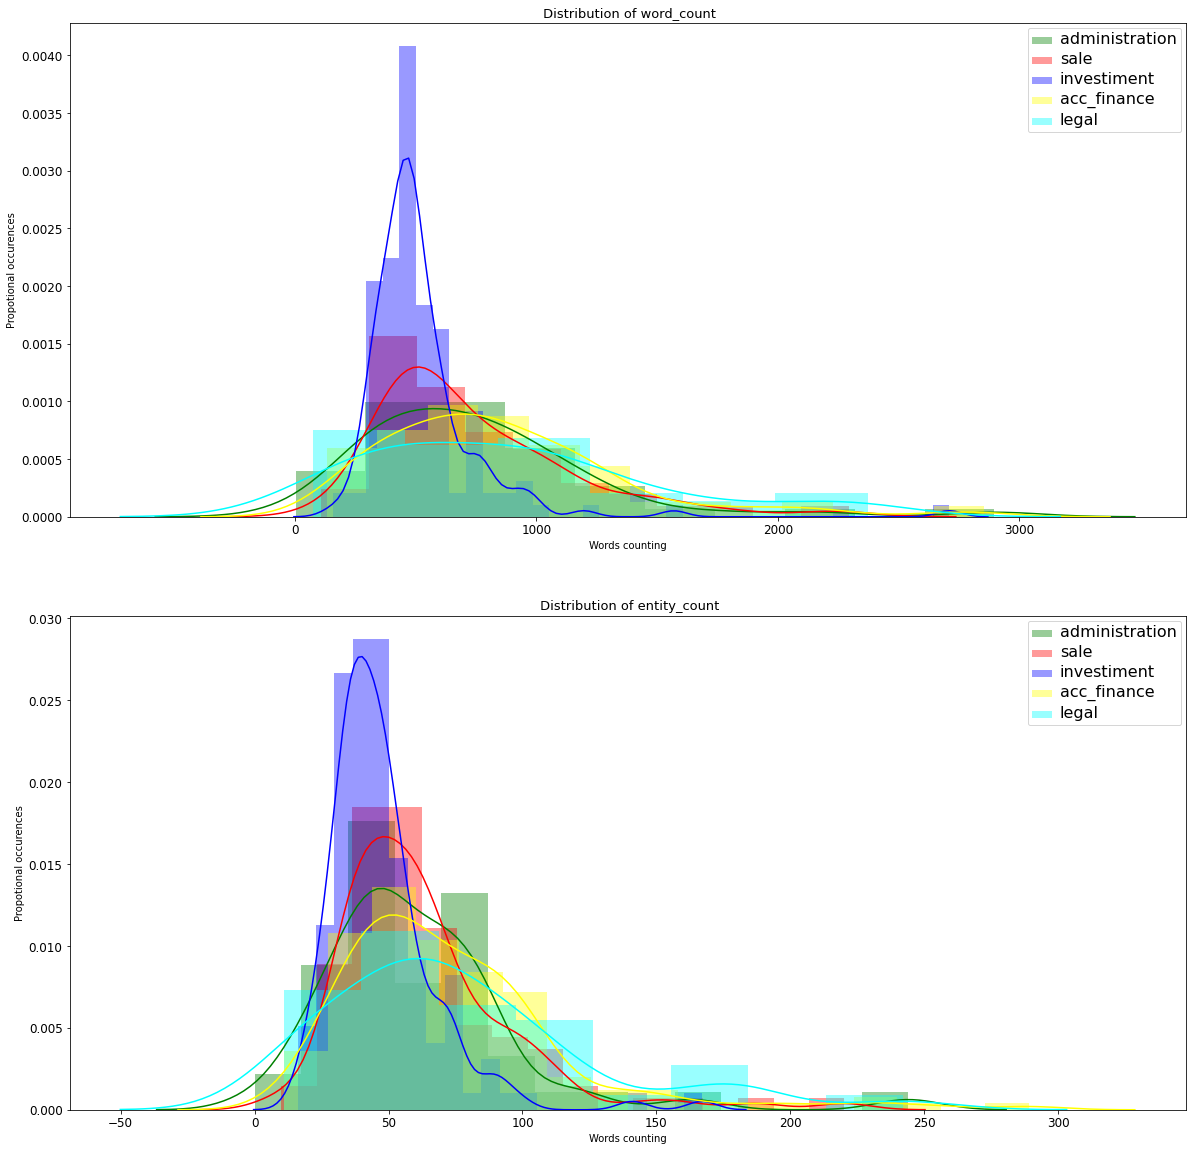

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

df_train = df
df_train['target'] = df_train['target'].astype(int)

data_headers = ['word_count', 'entity_count']

adm = df_train['target'] == 0
sales = df_train['target'] == 1
invest = df_train['target'] == 2
acc_fin = df_train['target'] == 3
legal = df_train['target'] == 4

ncols = 1
nrows = len(data_headers)
figsize =(20,20)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)

for i, targets in enumerate(data_headers):
  
    sns.distplot(df_train.loc[adm][targets], label='administration', ax=ax[i], color='green')
    sns.distplot(df_train.loc[sales][targets], label='sale', ax=ax[i], color='red')
    sns.distplot(df_train.loc[invest][targets], label='investiment', ax=ax[i], color='blue')
    sns.distplot(df_train.loc[acc_fin][targets], label='acc_finance', ax=ax[i], color='yellow')
    sns.distplot(df_train.loc[legal][targets], label='legal', ax=ax[i], color='cyan')

    ax[i].set_xlabel('Words counting')
    ax[i].set_ylabel('Propotional occurences')
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].legend()
    ax[i].set_title(f' Distribution of {targets}', fontsize=13)
    plt.setp(ax[i].get_legend().get_texts(), fontsize='16')

plt.show()


In [6]:
df1 = df.groupby(['target'])['word_count','entity_count'].agg(['mean', 'std']).reset_index()
df1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


target  word_count             entity_count           
                mean         std         mean        std
0      0  757.942308  503.595598    61.557692  38.863973
1      1  740.281553  406.051369    63.223301  32.731208
2      2  525.781690  263.414974    47.415493  20.375985
3      3  861.967320  512.674135    73.647059  44.288895
4      4  886.052632  605.949822    76.394737  50.892329

### Well, df1 shows how 'unstable?' is this kind of problem. These texts have not quite the same sizing, and there are many entities, like dates, places, organizations, personal details. Let's remove it, sounds it is close to 10% of total data. As much as I can, I shall find what is common to all of them, and then I will remove those fragments, so I will have a clean, solid and valueble(for each class) word tokens to feed the model :)

In [7]:
def check_orgs(text):
  doc = nlp(text)
  # print(doc)
  all = [ ((ent.text, ent.label_)) for ent in doc.ents] 
  orgs = [ ((ent.text, ent.label_)) for ent in doc.ents if ent.label_ in ('ORG') ] 
  print(all)
  print(orgs)

random_text = df['text'].iloc[0]
check_orgs(random_text)

[('VITAE', 'PERSON'), ('Availability         ', 'ORG'), ('SinoPac Asset Management Asia Ltd', 'ORG'), ('Jul', 'PERSON'), ('daily', 'DATE'), ('daily', 'DATE'), ('minutes', 'TIME'), ('weekly', 'DATE'), ('Liaison', 'PERSON'), ('Funds Insurance Securities', 'ORG'), ('Assist', 'NORP'), ('RQFII', 'ORG'), ('Krispace Design', 'PERSON'), ('Jun', 'PERSON'), ('July', 'DATE'), ('the Labour Ordinance', 'WORK_OF_ART'), ('Ordinance', 'ORG'), ('MPF', 'ORG'), ('Ordinance', 'ORG'), ('one', 'CARDINAL'), ('MPF', 'ORG'), ('Assist', 'NORP'), ('minutes', 'TIME'), ('annual', 'DATE'), ('annual', 'DATE'), ('daily', 'DATE'), ('Ordinance', 'ORG'), ('MPF', 'ORG'), ('Ordinance', 'ORG'), ('daily', 'DATE'), ('Ricacorp Properties Ltd', 'ORG'), ('second', 'ORDINAL'), ('Recommend', 'ORG'), ('Property Consultant Centaline Property Ltd', 'ORG'), ('Property Negotiator', 'ORG'), ('NovDec   Dealer  ', 'ORG'), ('Financial Markets Department Bank', 'ORG'), ('daily', 'DATE'), ('daily', 'DATE'), ('daily', 'DATE'), ('Sinopac Capi

### Before going further on cleaning text, more analysis are needed. What should I clean? I must remove garbages, but how, which one? So I need to understand what is written in these resumes. 

### Last cell has shown that some relevant words are being labeled as ORG. As example:

1.   ('SinoPac Asset Management Asia Ltd', 'ORG')
2.   ('Funds Insurance Securities', 'ORG')
3.   ('Private and Investment Banking Operations Dept Hang Seng Bank', 'ORG')
4.   ('the Hong Kong Institute of Bankers', 'ORG')

### There are keywords for resumes classification here, as 'Asset', 'Management', 'Funds', 'Insurance'. So, I will not remove it, but we still have not useful data, as 'SinoPac', 'Hang Seng' and 'Honk Kong'. 

### For this problem, 'SinoPac', and 'Hang Seng' can be removed by removing all Non-English words, and 'Honk Kong and Asia' is being removed byremoving GPE from the text. Now, we have a more valueable text.



### Now, remove few entities, non-english words, stop words and single characters. 



In [ ]:

def remove_entity(text):
  words = set(brown.words())
  doc = nlp(text)
  remove = [ "".join(ent.text) for ent in doc.ents if ent.label_ in ('GPE','DATE','NORP') ] 
  for word in remove:
    token = word
    text = str(text).lower()
  text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
  text = " ".join(w for w in text.split() if len(w) > 1)
  print(text)
  return text

def remove_stopword(text):
    words = [word for word in text if word not in stopwords.words('english')]
    words = ' '.join(words)
    return words

df['text'] = df['text'].apply(lambda x: remove_entity(x))
tokenizer = nltk.tokenize.WhitespaceTokenizer()
df['text'] = df['text'].apply(lambda x: tokenizer.tokenize(x))
df['text'] = df['text'].apply(lambda x : remove_stopword(x))

In [10]:
stemmer = nltk.stem.PorterStemmer()
lemmatizer=nltk.stem.WordNetLemmatizer()

df['text'] = df['text'].apply(lambda x: lemmatizer.lemmatize(x))

xtrain, xvalid, ytrain, yvalid = train_test_split(df.text, df.target, random_state=42, test_size=0.2, shuffle=True)

count_vectorizer = CountVectorizer()
xtrain_vectors = count_vectorizer.fit_transform(xtrain)
xvalid_vectors = count_vectorizer.transform(xvalid)


### Let's see how good is XGBoost. For now, all params are 'kinda' default. I am using f1_score to avaliate how is it going and set avarege to None to see all 5 classes' accuracy.

In [11]:
clf = xgb.XGBClassifier(max_depth=5, n_estimators=300, colsample_bytree=0.8, 
                        subsample=0.5, nthread=10, learning_rate=0.1)
clf.fit(xtrain_vectors, ytrain)

predictions = clf.predict(xvalid_vectors)
print('XGBClassifier on CountVectorizer')
print ("f1_score :", np.round(f1_score(yvalid, predictions, average=None),5))

XGBClassifier on CountVectorizer
f1_score : [0.82353 0.84    0.88    0.9375  0.93333]


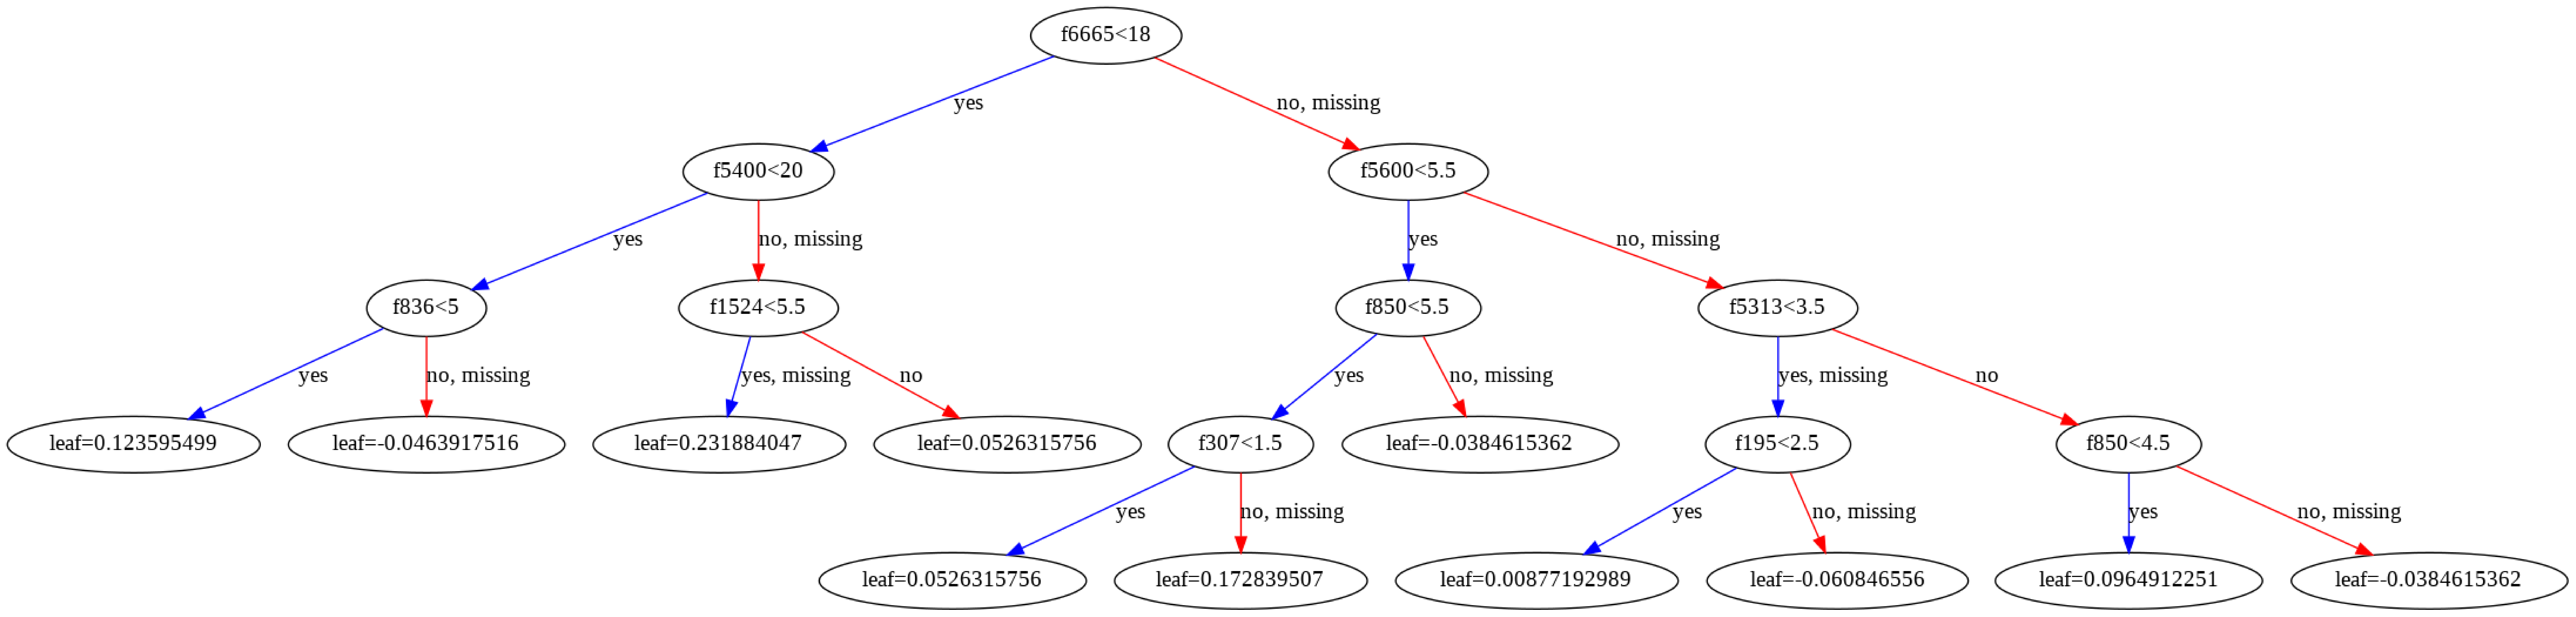

In [12]:
import matplotlib.pyplot
xgb.plot_tree(clf, num_trees=2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(250, 100)
fig.savefig('tree.png')

In [ ]:
pickle.dump(clf, open("pima.pickle.dat", "wb"))

### It was a good result, but... perhaps we can improve it, lets check the n-grams. To find the most common words and 'combined words'(ngrams).

# N-gram, for N = 1

In [26]:
from collections import defaultdict

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
adm_unigrams = defaultdict(int)
sal_unigrams = defaultdict(int)
inv_unigrams = defaultdict(int)
acc_unigrams = defaultdict(int)
leg_unigrams = defaultdict(int)

adm = df['target'] == 0
sales = df['target'] == 1
invest = df['target'] == 2
acc_fin = df['target'] == 3
legal = df['target'] == 4

for sentence in df[adm]['text']:
    for word in generate_ngrams(sentence):
        adm_unigrams[word] += 1
        
for sentence in df[sales]['text']:
    for word in generate_ngrams(sentence):
        sal_unigrams[word] += 1

for sentence in df[invest]['text']:
    for word in generate_ngrams(sentence):
        inv_unigrams[word] += 1

for sentence in df[acc_fin]['text']:
    for word in generate_ngrams(sentence):
        acc_unigrams[word] += 1

for sentence in df[legal]['text']:
    for word in generate_ngrams(sentence):
        leg_unigrams[word] += 1
        
adm_unigrams = pd.DataFrame(sorted(adm_unigrams.items(), key=lambda x: x[1])[::-1])
sal_unigrams = pd.DataFrame(sorted(sal_unigrams.items(), key=lambda x: x[1])[::-1])
inv_unigrams = pd.DataFrame(sorted(inv_unigrams.items(), key=lambda x: x[1])[::-1])
acc_unigrams = pd.DataFrame(sorted(acc_unigrams.items(), key=lambda x: x[1])[::-1])
leg_unigrams = pd.DataFrame(sorted(leg_unigrams.items(), key=lambda x: x[1])[::-1])

inv_unigrams[:20]

,0,1
0,investment,656
1,financial,624
2,research,602
3,management,460
4,analysis,444
5,china,419
6,company,412
7,business,367
8,equity,343
9,analyst,337


#N-grams, for N = 2

In [24]:
from collections import defaultdict

def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
adm_unigrams = defaultdict(int)
sal_unigrams = defaultdict(int)
inv_unigrams = defaultdict(int)
acc_unigrams = defaultdict(int)
leg_unigrams = defaultdict(int)

adm = df['target'] == 0
sales = df['target'] == 1
invest = df['target'] == 2
acc_fin = df['target'] == 3
legal = df['target'] == 4

for sentence in df[adm]['text']:
    for word in generate_ngrams(sentence):
        adm_unigrams[word] += 1
        
for sentence in df[sales]['text']:
    for word in generate_ngrams(sentence):
        sal_unigrams[word] += 1

for sentence in df[invest]['text']:
    for word in generate_ngrams(sentence):
        inv_unigrams[word] += 1

for sentence in df[acc_fin]['text']:
    for word in generate_ngrams(sentence):
        acc_unigrams[word] += 1

for sentence in df[legal]['text']:
    for word in generate_ngrams(sentence):
        leg_unigrams[word] += 1
        
adm_unigrams = pd.DataFrame(sorted(adm_unigrams.items(), key=lambda x: x[1])[::-1])
sal_unigrams = pd.DataFrame(sorted(sal_unigrams.items(), key=lambda x: x[1])[::-1])
inv_unigrams = pd.DataFrame(sorted(inv_unigrams.items(), key=lambda x: x[1])[::-1])
acc_unigrams = pd.DataFrame(sorted(acc_unigrams.items(), key=lambda x: x[1])[::-1])
leg_unigrams = pd.DataFrame(sorted(leg_unigrams.items(), key=lambda x: x[1])[::-1])

inv_unigrams

,0,1
0,due diligence,132
1,equity research,115
2,real estate,111
3,financial models,108
4,investment banking,76
...,...,...
21542,funds research,1
21543,long funds,1
21544,years years,1
21545,worked investment,1


###2-grams carries many information, the most common 2-grams are (for example, in INVESTMENT) ['equity research', 'financial models']. For the less common 2-grams there are some as, ['worked invesment', 'funds research'], even these words "invesment, fund and research" are top20 words in the investment dataset.
###What does it means? It means I will use 1-gram sequence to clean again the dataset(removing N 1-grams from it) because I will not lose import words.

In [28]:
adm_dic = adm_unigrams[adm_unigrams.iloc[:,1] > 11]
adm_dic = adm_dic.iloc[:,0].to_list()

sal_dic = sal_unigrams[sal_unigrams.iloc[:,1] > 11]
sal_dic = sal_dic.iloc[:,0].to_list()

inv_dic = inv_unigrams[inv_unigrams.iloc[:,1] > 11]
inv_dic = inv_dic.iloc[:,0].to_list()

acc_dic = acc_unigrams[acc_unigrams.iloc[:,1] > 11]
acc_dic = acc_dic.iloc[:,0].to_list()

leg_dic = leg_unigrams[leg_unigrams.iloc[:,1] > 11]
leg_dic = leg_dic.iloc[:,0].to_list()

In [27]:
af = df
del af['word_count']
del af['entity_count']

def remove_stopword1(text, my_dict):
  remove = [ "".join(word) for word in text.split() if word in (my_dict) ] 
  remove = ' '.join(remove)
  return remove

adm = df['target'] == 0
sales = df['target'] == 1
invest = df['target'] == 2
acc_fin = df['target'] == 3
legal = df['target'] == 4

af["target"] = pd.to_numeric(df["target"])

af.loc[adm, ['text']] = af['text'].apply(lambda x: remove_stopword1(x, adm_dic))
af.loc[sales, ['text']] = af['text'].apply(lambda x: remove_stopword1(x, sal_dic))
af.loc[invest, ['text']] = af['text'].apply(lambda x: remove_stopword1(x, inv_dic))
af.loc[acc_fin, ['text']] = af['text'].apply(lambda x: remove_stopword1(x, acc_dic))
af.loc[legal, ['text']] = af['text'].apply(lambda x: remove_stopword1(x, leg_dic))

In [16]:
stemmer = nltk.stem.PorterStemmer()
lemmatizer=nltk.stem.WordNetLemmatizer()

af['text'] = af['text'].apply(lambda x: lemmatizer.lemmatize(x))


xtrain, xvalid, ytrain, yvalid = train_test_split(af.text, af.target, random_state=42, test_size=0.2, shuffle=True)

count_vectorizer = CountVectorizer()
xtrain_vectors = count_vectorizer.fit_transform(xtrain)
xvalid_vectors = count_vectorizer.transform(xvalid)

In [17]:
clf = xgb.XGBClassifier(max_depth=5, n_estimators=300, colsample_bytree=0.8, 
                        subsample=0.5, nthread=10, learning_rate=0.1)
clf.fit(xtrain_vectors, ytrain)

predictions = clf.predict(xvalid_vectors)
print('XGBClassifier on CountVectorizer')
print ("f1_score :", np.round(f1_score(yvalid, predictions, average=None),5))

XGBClassifier on CountVectorizer
f1_score : [0.88889 0.875   0.88    0.95385 0.93333]


In [21]:
print ("f1_score :", np.round(f1_score(yvalid, predictions,average='micro'),5))

f1_score : 0.90816


# Removing words appearing less than 6 times
####Avarage = None > [0.82353 0.84    0.88    0.9375  0.93333]
####Avarage = Micro > f1_score : 0.90816

# Removing words appearing less than 11 times
####Avarage = None > [0.88889 0.89796 0.91667 0.9697  0.93333]
####Avarage = Micro > f1_score : 0.92857

# Removing words appearing less than 31 times
####Avarage = None > [0.94737 0.96    0.95652 0.98462 1.     ]
####Avarage = Micro > f1_score : 0.96939


In [ ]:
# uploaded = files.upload()
# conteudoUploaded = str(uploaded)
# nomeArquivo = re.findall(r"'(.*?)'", conteudoUploaded, re.DOTALL)
#count_vectorizer = pickle.load(open("vectorizer.pkl", "rb"))

## I have download few resume from: dayjob.com, template.net, resumeviking and others. And not of them were used for training.

In [22]:
uploaded = files.upload()
conteudoUploaded = str(uploaded)
nomeArquivo = re.findall(r"'(.*?)'", conteudoUploaded, re.DOTALL)

realtest = pd.read_csv(nomeArquivo[0], index_col = False, dtype=object)
realtest.head()

Saving testes15.csv to testes15.csv


,text
0,|[pic] |colin Tan ...
1,Name: Wong Yi (Wang Yi) (çŽ‹ æ¯…) Advocate an...
2,"PANG WING TUNG, CA..."
3,1. PERSONAL PARTICULARS Name ...
4,"LIM LIAN CHING, ANGIE Address : Blk 5..."


In [23]:
realtest=realtest.iloc[:,0]
realtest.head()

0     |[pic]                   |colin Tan          ...
1    Name: Wong Yi (Wang Yi) (çŽ‹ æ¯…)  Advocate an...
2                                PANG WING TUNG, CA...
3           1. PERSONAL PARTICULARS          Name  ...
4    LIM LIAN CHING, ANGIE    Address       : Blk 5...
Name: text, dtype: object

In [24]:
# uploaded = files.upload()
# conteudoUploaded = str(uploaded)
# nomeArquivo = re.findall(r"'(.*?)'", conteudoUploaded, re.DOTALL)
# bst = pickle.load(open("pima.pickle.dat", "rb"))

In [25]:
def remove_entity(text):
  words = set(brown.words())
  doc = nlp(text)
  remove = [ "".join(ent.text) for ent in doc.ents if ent.label_ in ('GPE','DATE','NORP') ] 
  for word in remove:
    token = word
    text = str(text).lower()
  text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
  text = " ".join(w for w in text.split() if len(w) > 1)
  return text

def remove_stopword(text):
    words = [word for word in text if word not in stopwords.words('english')]
    return words

def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

def clean_text(text):
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('|', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', '', text)
    return text

tokenizer = nltk.tokenize.WhitespaceTokenizer()
stemmer = nltk.stem.PorterStemmer()
lemmatizer=nltk.stem.WordNetLemmatizer()

pred = realtest.apply(lambda x: clean_text(x))
print('clean')
pred = pred.apply(lambda x: remove_entity(x))
print('entity')
pred = pred.apply(lambda x: tokenizer.tokenize(x))
print('token')
pred = pred.apply(lambda x : remove_stopword(x))
print('stopword')
pred = pred.apply(lambda x : combine_text(x))
print('combine')
pred = pred.apply(lambda x: lemmatizer.lemmatize(x))
print('lemma')
print(pred)
pred_vectors = count_vectorizer.transform(pred)
print('transform')
predictions = clf.predict(pred_vectors)	
print('predicted')

clean
entity
token
stopword
combine
lemma
0     tan objective corporate legal internal charter...
1     name advocate solicitor supreme court republic...
2     wing tung castle personal data sex female date...
3     personal particulars name contact number mail ...
4     address address mobile summary dedicated metic...
5     curriculum road contact curriculum key highlig...
6     mobile address road east meadows tower years i...
7     professional experience advisory assistant man...
8     block street education pursuing chartered acco...
9     work experience advisory services present merg...
10    wee cellular number address work experience se...
11    curriculum william wee personal information na...
12    view echelon summary license holder years expe...
13    born road years experience wealth management i...
14    lung court cape road experience current employ...
15    age marital status single education bachelor b...
Name: text, dtype: object
transform
predicted


In [26]:
print(predictions)

[4 4 3 3 3 3 2 2 2 2 1 1 1 1 0 0]


# Answer = ['4' '4' '3' '3' '3' '3' '2' '2' '2' '2' '1' '1' '1' '1' '0' '0']

### I do not have a large dataset, so there are not much dataset to valid it, then, for production, I choose fit the matrix of tokens removing the N-grams based on its propotion from the training dataset. Now its being used ngram_range from CountVectorizer, and removing the less common 10% of the whole dataset.


In [21]:
count_vectorizer = CountVectorizer(ngram_range=(1,1), min_df = 0.1)
xtrain_vectors = count_vectorizer.fit_transform(xtrain)
xvalid_vectors = count_vectorizer.transform(xvalid)

clf = xgb.XGBClassifier(max_depth=5, n_estimators=300, colsample_bytree=0.8, 
                        subsample=0.5, nthread=10, learning_rate=0.1)
clf.fit(xtrain_vectors, ytrain)

predictions = clf.predict(xvalid_vectors)
print('XGBClassifier on CountVectorizer')
print ("f1_score :", np.round(f1_score(yvalid, predictions, average=None),5))
print ("f1_score :", np.round(f1_score(yvalid, predictions, average='micro'),5))

XGBClassifier on CountVectorizer
f1_score : [0.82353 0.86275 0.89362 0.9697  0.93333]
f1_score : 0.90816


#Conclusion
##This is small project running on : http://18.212.64.153/ . 
##Flask API on AWS(fastAPI is recommended, but there are few requisitions/min).
##Unfortunatelly, I couldn't run BERT on my computer(RAM limit > OOM, limiting my batch size), but should be implement for studies, for sure, bacause it issupposed to be the state of art. A gloVe's model would be fine too. But for being straight to the point, I have used XGBoost + simple tokenization from NLTK.

##Grid Search are taking around 16 hours to run, I have run it once, but without most of my analysis on text, so it values are not accurate. But for fine tunning, a GridSearch would be great, and a larger dataset would be cool.

